# Third version of ML model

In [51]:
# import all needed libs
import pandas as pd
import numpy as np

# read datasets into datadframe
train_set = pd.read_pickle('../train_val_test_data/train_set.pkl')
validation_set = pd.read_pickle('../train_val_test_data/validation_set.pkl')
test_set = pd.read_pickle('../train_val_test_data/test_set.pkl')

# Remove all NaN rows / TODO: investigate and improve this 
train_set = train_set.dropna(subset=['Umsatz'])
validation_set = validation_set.dropna(subset=['Umsatz'])

# check if NaN left
#print(test_set.isna().sum())

#train_set.head()

train_set.columns

Index(['Datum', 'Warengruppe', 'Umsatz', 'Bewoelkung', 'Temperatur',
       'Windgeschwindigkeit', 'Wettercode', 'Jahr_Monat', 'monthly_mean_temp',
       'monthly_mean_temp_diff', 'sunny', 'Wind_Kategorie', 'rainday',
       'snowday', 'KielerWoche', 'Salesindex', 'HolyCode', 'SchholCode',
       'BinHoly', 'BinSchhol', 'BinElec', 'DayOfWeek', 'weekend'],
      dtype='object')

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

def prepare_features(data_df):
    # Define categorical features
    categorical_features = ['Warengruppe', 'Wind_Kategorie', 'DayOfWeek']

    # Ensure categorical columns are treated as categories
    for col in categorical_features:
        data_df[col] = data_df[col].astype('category')

    # Encode categorical variables using pd.get_dummies
    features = pd.get_dummies(data_df[categorical_features], drop_first=True, dtype=int)

    # Include any numeric or binary columns that are not categorical
    features['sunny'] = data_df['sunny']
    features['rainday'] = data_df['rainday']
    features['snowday'] = data_df['snowday']
    features['Salesindex'] = data_df['Salesindex']
    features['monthly_mean_temp_diff'] = data_df['monthly_mean_temp_diff']
    features['KielerWoche'] = data_df['KielerWoche']
    features['BinHoly'] = data_df['BinHoly']
    features['BinSchhol'] = data_df['BinSchhol']
    features['weekend'] = data_df['weekend']

    return features

# We need separated features and labels

# create the lable first
training_features =prepare_features(train_set)
validation_features = prepare_features(validation_set)
test_features = prepare_features(test_set)

# Add Umsatz to training and validation lables
training_labels = train_set[['Umsatz']]
validation_labels = validation_set[['Umsatz']]
# test_data contains no lable for Umsatz 

# Convert DataFrames to numpy arrays
training_features_array = training_features.to_numpy()
training_labels_array = training_labels.to_numpy().flatten()  # Flatten in case labels are a DataFrame with one column

model = Sequential([
  InputLayer(shape=(training_features.shape[1], )),
  BatchNormalization(),
  Dense(64, activation='relu'),
  Dropout(0.1),
  Dense(32, activation='relu'),
  Dropout(0.1),
  Dense(16, activation='relu'),
  Dropout(0.1),
  Dense(8, activation='relu'),
  Dense(1, activation='linear')
])

model.summary()

model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))

# Early Stopping Callback to prevent overfitting and long waiting for convergations
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)



history = model.fit(training_features, training_labels, epochs=250,
                    validation_data=(validation_features, validation_labels),  
                    callbacks=[early_stopping])

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_16          │ (None, 21)             │            84 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,245 (16.58 KB)

 Trainable params: 4,203 (16.42 KB)

 Non-trainable params: 42 (168.00 B)

Epoch 1/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 64260.3633 - val_loss: 33543.0898
Epoch 2/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9907.0938 - val_loss: 4909.6533
Epoch 3/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7814.8252 - val_loss: 4723.3672
Epoch 4/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9359.3887 - val_loss: 4630.6714
Epoch 5/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7848.3506 - val_loss: 4618.1240
Epoch 6/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7333.0435 - val_loss: 4525.4556
Epoch 7/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8639.7061 - val_loss: 4668.6045
Epoch 8/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8083.0854 - val_loss: 4416.7612
Epoch 9/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7993.0557 - val_loss: 4398.6035
Epoch 10/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7084.3940 - val_loss: 4392.6162
Epoch 11/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7369.

In [53]:
model.save("python_model_v3.keras")

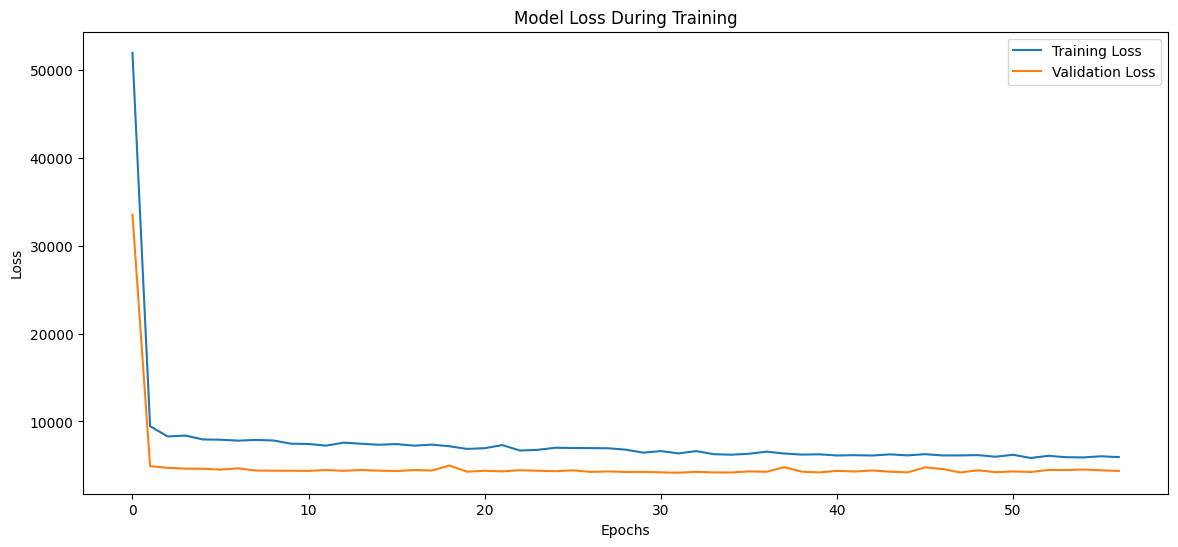

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Making Predictions and Evaluating the Model
Let's use the model to make predictions on our training and validation sets and evaluate the model's performance using Mean Absolute Percentage Error (MAPE).

In [60]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
MAPE on the Training Data: 24.18%
MAPE on the Validation Data: 25.48%


### Plot predictions

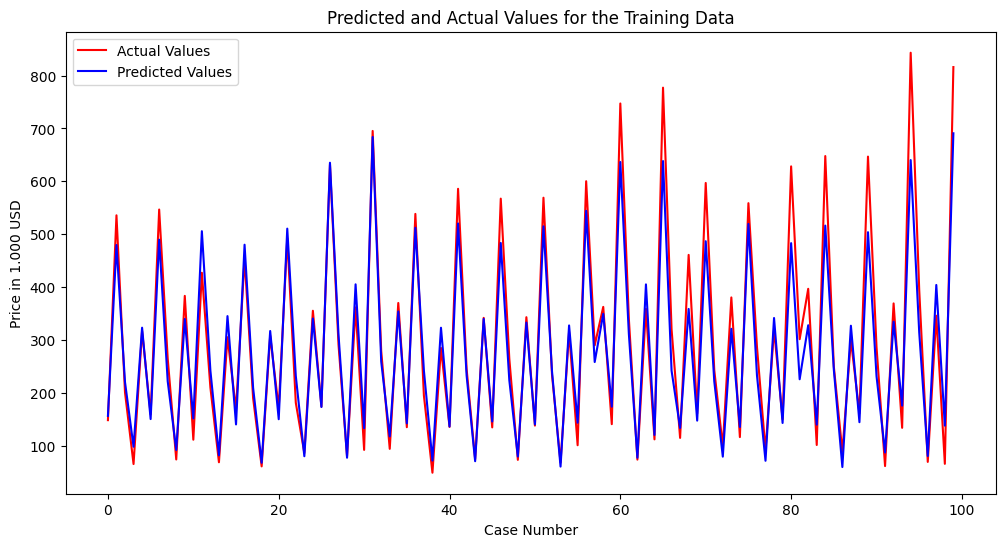

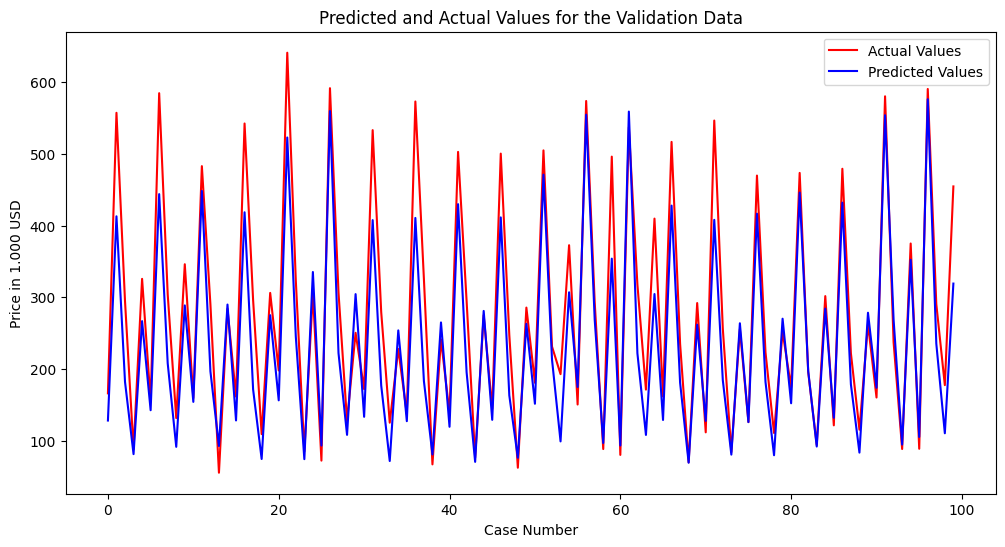

In [56]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Case Number')
    plt.ylabel('Price in 1.000 USD')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

### Calculate test results to submit to kaggle

In [57]:
# calculate predictions for testdata
test_predictions = model.predict(test_features)

# flatten and convert from numpy into pandas dataframe
test_predictions = np.array(test_predictions).flatten()
test_predictions_df = pd.DataFrame({'Umsatz': test_predictions})

test_predictions_df.head()

test_set.head()

# merge the IDs from test date togther with Umsatz predictions
# TODO: check if we have any problems because of no common date index on both dataframes
submission_set = pd.concat([test_set['id'], test_predictions_df['Umsatz']], axis=1)

# Check if the count of dataset is correct for kaggle upload
if submission_set.shape[0] == 1830:
    print("OK : DataFrame has exact 1830 Entries!")
else:
    print(f"ERROR Dataframe has wrong number of {submission_set.shape[0]} Entries!")

# store the submission data
submission_set.to_csv('../prediction_data/submission.csv', index=False)

 1/58 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
OK : DataFrame has exact 1830 Entries!
